## Attention : L'étape d'installation est à faire pour google Colab seulement
## 1 Installation de  pyspark et configuration de Colab
Nous devons d'abord installer et configurer pyspark car il n'est pas installé par défaut dans l'environnement d'exécution Colab. L'installation de pyspark persistera jusqu'à ce que le runtime soit recyclé.


Installation des dépendances:


1.   Java 8
2.   Apache Spark with hadoop and
3.   Findspark (used to locate the spark in the system)


In [ ]:
# Executer seulement si on travaille sur Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
!ls
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark


logo.png  sample_data  spark-3.1.1-bin-hadoop3.2  spark-3.1.1-bin-hadoop3.2.tgz



## 2 Initialisation de Spark

Il s'agit du démarrage typique pour que Spark fonctionne en mode standalone. On obtient:

- `spark` : un objet `SparkSession` - ce notebook agit comme __driver program__  qui communique avec Spark via la session Spark (nous parlerons de l'architecture interne de Spark dans le cours).

- `sc` : un objet `SparkContext` qui expose l'API de bas niveau de Spark.


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=20eaeb3880b7059e22523ebd2b76b5b8514c98d15a128f2f42466858ba92bf44
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [1]:
#commencer ici avec jupyter
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .master('local[*]')\
        .getOrCreate()
sc = spark.sparkContext

ModuleNotFoundError: No module named 'pyspark'

## 3 Introduction à Spark RDDs


Cette partie présente l'utilisation des ensembles de données distribués résilients (RDD) dans Spark. Les RDD sont à la base de l'API "bas niveau" de Spark. Bien que nous utiliserons principalement l'API DataFrame de niveau supérieur, les RDD sont plus pratiques pour introduire un certain nombre de concepts de base dans Spark et pour exprimer des calculs de type MapReduce.

__References__:
  - [RDD API documentation](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.html).

### C'est quoi un RDD?

Les RDD sont "une collection immuable et partitionnée d'éléments qui peuvent être utilisés en parallèle". Ça signifie:

- Ils sont immuables, car vous ne pouvez pas modifier le contenu des RDD après les avoir créés.

- Leurs données sont réparties en plusieurs partitions.

- Les partitions peuvent être traitées en parallèle.

2 types d'opérations sur les RDDs [__transformations__](https://spark.apache.org/docs/latest/rdd-programming-guide.html#transformations) and [__actions__](https://spark.apache.org/docs/latest/rdd-programming-guide.html#actions):

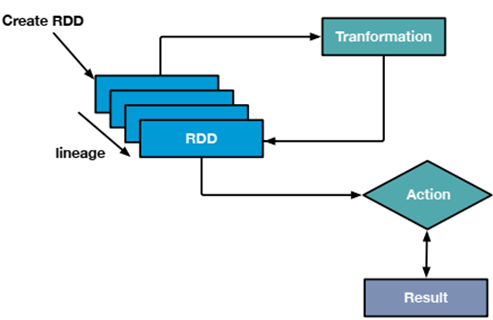

-__Transformations__ : crée un nouveau RDD à partir d'une source de données ou d'un RDD existant précédemment. Un graphe acyclique dirigé (DAG) de transformations (dans de nombreux cas prenant simplement la forme d'une séquence) qui définit un RDD est appelé le RDD __lineage__.

- _Les transformations_ sont évaluées __paresseusement__, ce qui signifie qu'elles ne s'exécuteront que lorsqu'elles seront déclenchées par __actions__ qui renvoie une valeur au programme pilote.

-__Actions__ :
Une action consiste à appliquer une fonction et à retourner une valeur au programme driver pour par exemple les afficher sur l’écran ou les enregistrer dans un fichier.


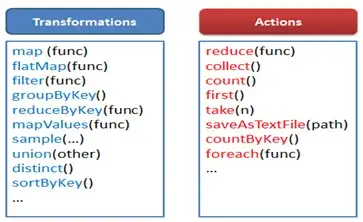

In [2]:
data = sc.parallelize([1,2,3,4,5])
print (data)

NameError: name 'sc' is not defined

In [1]:
data = sc.parallelize([(1,2),(3,4),(3,6),(3,4)])
print (data)
data.collect()

NameError: name 'sc' is not defined

In [ ]:
type(data)

pyspark.rdd.RDD

In [ ]:
data.count()

4

## 4. Transformations sur les RDD

Il existe deux types de transformations :

*   les dépendances étroites où chaque partition d’un parent RDD est utilisé par au  plus une partition d’un RDD enfant,

* les dépendances larges où plusieurs partitions filles peuvent dépendre d’une partition donnée.
Par exemple, la fonction map peut engendrer des dépendances étroites alors que la fonction join peut produire des dépendances larges.

Ces distinctions sont importantes car :


*   une dépendance étroite permet l’exécution en pipeline sur un seul noeud du
cluster. A l’inverse, une dépendance large nécessite que les données de toutes les partitions parentes soient présentes et il convient donc de les déplacer entre les noeuds en utilisant une opération de type MapReduce

*   la récupération après un noeud en échec est plus efficace avec une dépendance étroite puisque seules les partitions parentes perdues doivent être recalculées et que cela peut être fait en parallèle sur différents noeuds. A l’inverse, avec une dépendance large, un simple échec d’un noeud peut entrainer la perte de plusieurs partitions sur tous les ancêtres d’un RDD entraînant une réexécution complète des opérations.




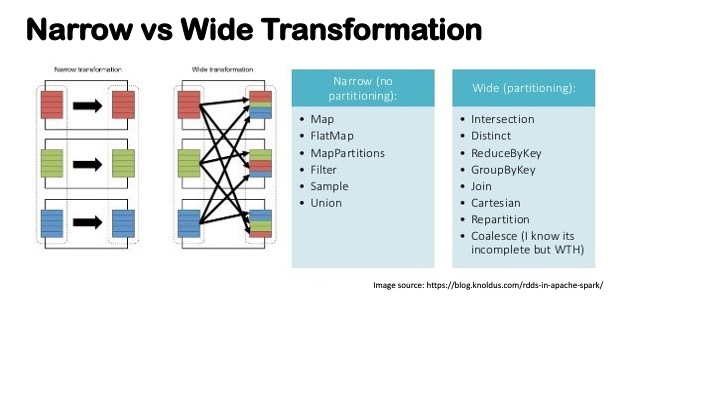

## Les transformations étroites (*narrow transformations*)

In [ ]:
Image(filename='Map.jpg')

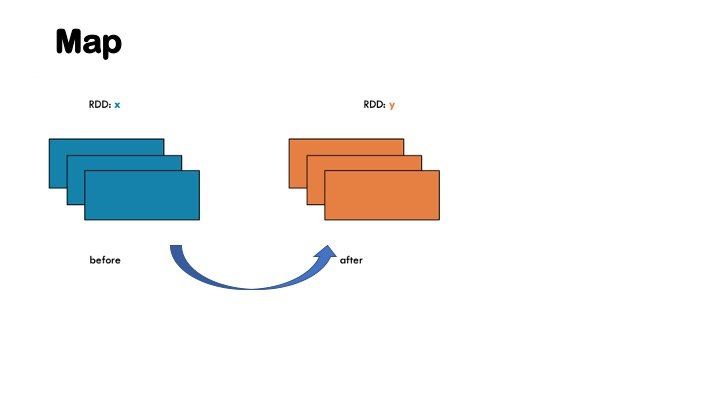

In [ ]:
num = sc.parallelize([5,5,4,3,2,9,2],4)
num.collect()
num.getNumPartitions()



1

In [ ]:
num.map(lambda a : a*2).collect()

[10, 10, 8, 6, 4, 18, 4]

In [ ]:
num.map(lambda a : pow(a,2)).collect()#a*a

[25, 25, 16, 9, 4, 81, 4]

In [ ]:
names = sc.parallelize([ "Bills", "Mark","Brain","Mick"])

In [ ]:
names.map(lambda a : "Mr. "+ a).collect()

['Mr. Bills', 'Mr. Mark', 'Mr. Brain', 'Mr. Mick']

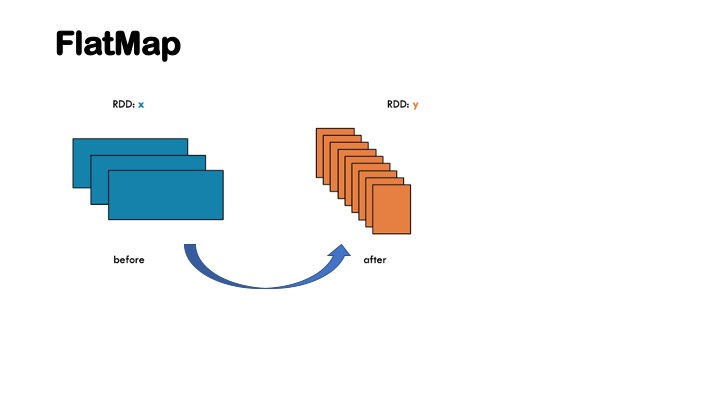

In [ ]:
Image(filename='FlatMap.jpg')

In [ ]:
rdd = sc.parallelize([ 2, 3,4])
rdd.collect()

[2, 3, 4]

In [ ]:
a = range(1,10)
for i in a:
    print(i)

1
2
3
4
5
6
7
8
9


In [ ]:
rdd.map(lambda x: range(1, x)).collect()

[range(1, 2), range(1, 3), range(1, 4)]

In [ ]:
rdd.flatMap(lambda x: range(1, x)).collect()

[1, 1, 2, 1, 2, 3]

In [ ]:
a = sc.parallelize([1,2,3])

In [ ]:
a.map(lambda x: (x,x*10,57)).collect()

[(1, 10, 57), (2, 20, 57), (3, 30, 57)]

In [ ]:
a.flatMap(lambda x: (x,x*10,57)).collect()

[1, 10, 57, 2, 20, 57, 3, 30, 57]

In [ ]:
#remarquer la différence avec map
a.map(lambda x: (x,x*10,57)).collect()

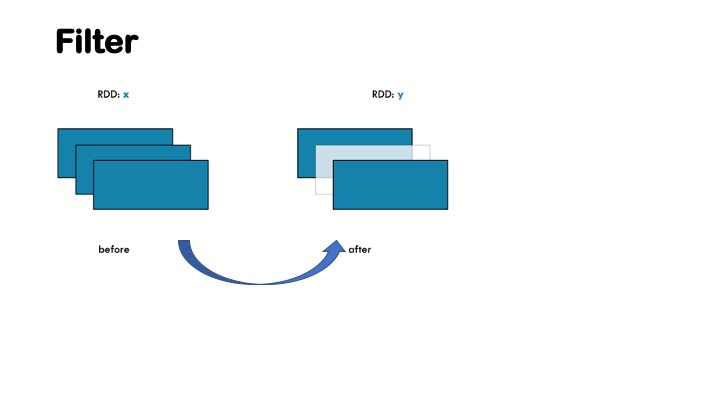

In [ ]:
Image(filename='Filter.jpg')

In [ ]:
num.collect()

[5, 5, 4, 3, 2, 9, 2]

In [ ]:
num.filter(lambda x : x%2 == 0).collect()

[4, 2, 2]

In [ ]:
names.collect()

['Bills', 'Mark', 'Brain', 'Mick']

In [ ]:
names.filter(lambda x : "a" in x).collect()

['Mark', 'Brain']

In [ ]:
names.filter(lambda x :x.startswith('M')).collect()


['Mark', 'Mick']

In [ ]:
names.sortBy(lambda x:x[0],1).collect()
#voir le tri descendant

['Bills', 'Brain', 'Mark', 'Mick']

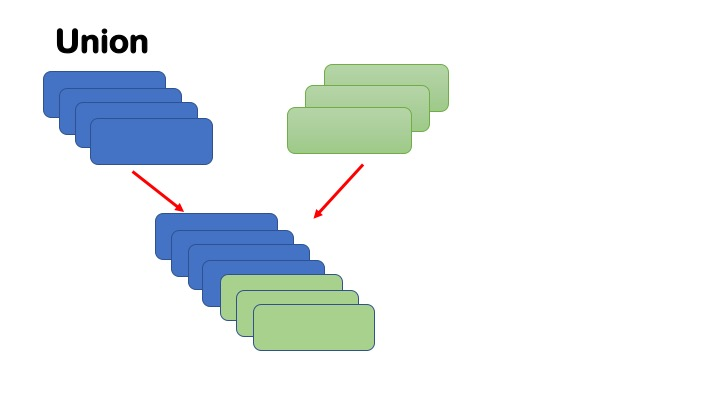

In [ ]:
Image(filename='Union.jpg')

In [ ]:
num.collect()

[5, 5, 4, 3, 2, 9, 2]

In [ ]:
num2 = sc.parallelize([1,7,9,4,10,15])
num2.collect()

[1, 7, 9, 4, 10, 15]

In [ ]:
num3=num2.union(num)
num3.distinct().collect()
#num3.sortBy('asc').collect()

[1, 15, 2, 3, 4, 5, 7, 9, 10]

In [ ]:
x = sc.parallelize([1,2,3], 2)
y = sc.parallelize([3,4], 1)

In [ ]:
z = x.union(y)
z.collect()

[1, 2, 3, 3, 4]

In [ ]:
# sample: Return a random sample subset RDD of the input RDD
# API: (withReplacement: Boolean, fraction: Double, seed: Long = Utils.random.nextLong): RDD[T]
# Note This is not guaranteed to provide exactly the fraction specified of the total count of the given


In [ ]:
parallel = sc.parallelize(range(1,20))
parallel.collect()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [ ]:
parallel.sample(True,.2,).collect()

[10, 15, 16]

In [ ]:
parallel.sample(True,.2,seed=19).collect()

[4, 7]

In [ ]:
parallel.sample(False,.2).collect()

[4, 9]

In [ ]:
parallel.sample(True,.2).collect()

[7]

In [ ]:
parallel.sample(False,.2,seed=23).collect()

[2, 3, 7]

### Transformations larges

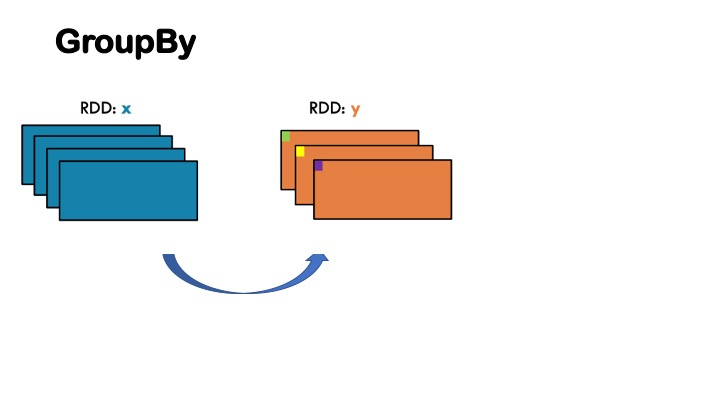

In [ ]:
Image(filename='GroupBy.jpg')

In [ ]:
names.collect()

['Bills', 'Mark', 'Brain', 'Mick']

In [ ]:
names_gr = names.groupBy(lambda x : x[0]).collect()

In [ ]:
names_gr

[('M', <pyspark.resultiterable.ResultIterable at 0x7f1f1b227340>),
 ('B', <pyspark.resultiterable.ResultIterable at 0x7f1f1b2a4f40>)]

In [ ]:
for (k,v) in names_gr:
    print(k,list(v))

M ['Mark', 'Mick']
B ['Bills', 'Brain']


In [ ]:
aa = sc.parallelize([1, 1, 2, 3, 5, 8])


In [ ]:
result = aa.groupBy(lambda x: x % 3).collect()

In [ ]:
result

[(0, <pyspark.resultiterable.ResultIterable at 0x7f1f1b224a30>),
 (1, <pyspark.resultiterable.ResultIterable at 0x7f1f1b2a5330>),
 (2, <pyspark.resultiterable.ResultIterable at 0x7f1f1b2a5000>)]

In [ ]:
for (k,v) in result:
    print(k, list(v) )

0 [3]
1 [1, 1]
2 [2, 5, 8]


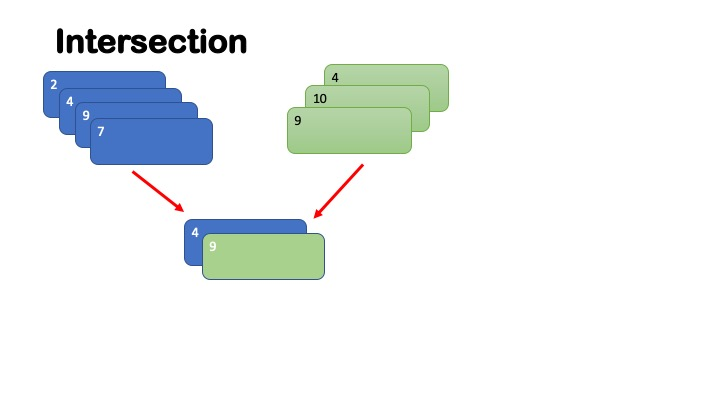

In [ ]:
Image(filename='Intersection.jpg')

In [ ]:
num.collect()

[5, 5, 4, 3, 2, 9, 2]

In [ ]:
num2.collect()

[1, 7, 9, 4, 10, 15]

In [ ]:
num.intersection(num2).collect()

[4, 9]

In [ ]:
num2.intersection(num).collect()

[4, 9]

In [ ]:
num.subtract(num2).collect()

[2, 2, 3, 5, 5]

In [ ]:
num2.subtract(num).collect() # equivalent de num2 privé de num

[1, 7, 10, 15]

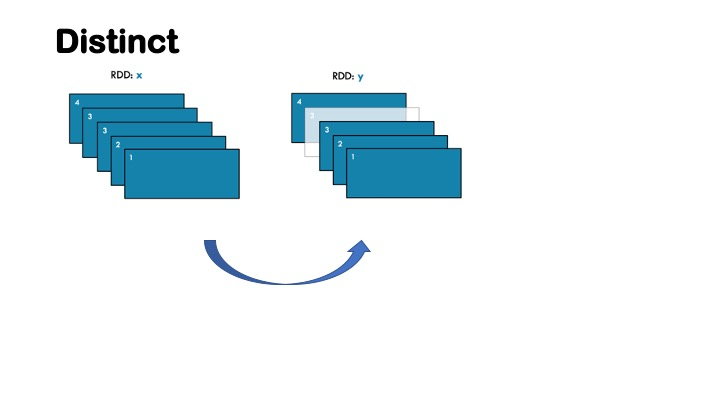

In [ ]:
Image(filename='Distinct.jpg')

In [ ]:
num.collect()

[5, 5, 4, 3, 2, 9, 2]

In [ ]:
num.distinct().collect()

[5, 4, 3, 2, 9]

In [ ]:
#Join

## Transformation sur les paires (Key, Value)

In [ ]:
data. collect()

[(1, 2), (3, 4), (3, 6), (3, 4)]

In [ ]:
data.countByValue()

defaultdict(int, {(1, 2): 1, (3, 4): 2, (3, 6): 1})

In [ ]:
data.count()

4

In [ ]:
dataStr = sc.parallelize([(1,'mike'),(2,'john'),(3,'rambo'),(4,'bill'),(1,'mike')])
dataStr.collect()

[(1, 'mike'), (2, 'john'), (3, 'rambo'), (4, 'bill'), (1, 'mike')]

In [ ]:
dataStr.count()

4

In [ ]:
dataStr.countByValue()

defaultdict(int,
            {(1, 'mike'): 2, (2, 'john'): 1, (3, 'rambo'): 1, (4, 'bill'): 1})

In [ ]:
data1.top(4)

[(3, 6), (3, 1), (2, 4), (1, 2)]

In [ ]:
data1= sc.parallelize([(1, 2), (3, 6), (3, 1), (2, 4)])

In [ ]:
data1.sortByKey().collect()

[(1, 2), (2, 4), (3, 6), (3, 1)]

In [ ]:
# lookup : Return all value associated with the given key.
data1.lookup(3)

[6, 1]

In [ ]:
data.keys().collect()

[1, 3, 3, 3]

In [ ]:
data.values().collect()

[2, 4, 6, 4]

In [ ]:
data.mapValues(lambda a : a*a).collect()

[(1, 4), (3, 16), (3, 36), (3, 16)]

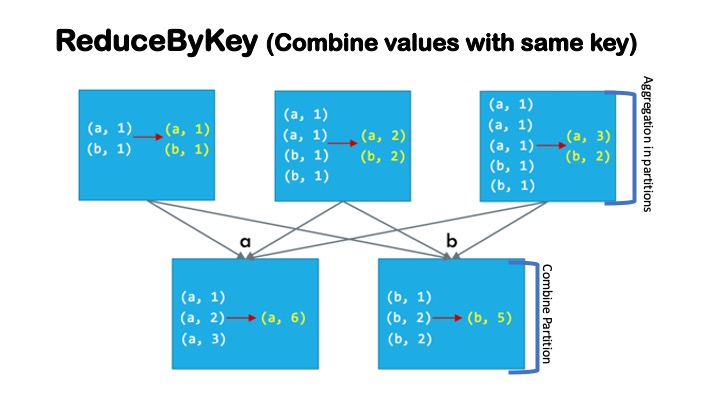

In [ ]:
Image(filename='ReduceByKey.jpg')

In [ ]:
data.collect()

[(1, 2), (3, 4), (3, 6), (3, 4)]

In [ ]:
data.reduceByKey(lambda x, y : x+y).collect()

[(1, 2), (3, 14)]

In [ ]:
data.reduceByKey(max).collect()

[(1, 2), (3, 6)]

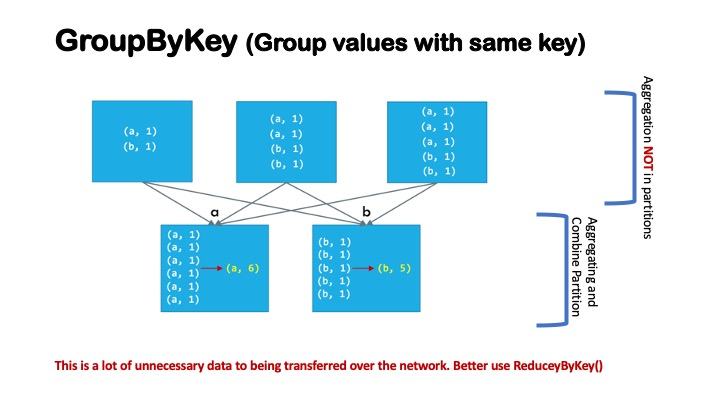

In [ ]:
Image(filename='GroupByKey.jpg')

In [ ]:
# groupBy: This transformation groups all the rows with the same key into a single row.
result = data.groupByKey().collect()

In [ ]:
result

[(1, <pyspark.resultiterable.ResultIterable at 0x1a4b23c4048>),
 (3, <pyspark.resultiterable.ResultIterable at 0x1a4b23c4bc8>)]

In [ ]:
for (k,v) in result:
    print(k, list(v))

1 [2]
3 [4, 6, 4]


In [ ]:
aa = data.groupByKey().mapValues(sum)

In [ ]:
aa.collect()

[(1, 2), (3, 14)]

In [ ]:
bb = data.groupByKey().mapValues(max)

In [ ]:
bb.collect()

[(1, 2), (3, 6)]

In [ ]:
# reduceByKey = gropupByKey().mapValues(), then what is the difference ??

In [ ]:
data.collect()

[(1, 2), (3, 4), (3, 6), (3, 4)]

In [ ]:
data.flatMapValues(lambda x: range(1, x)).collect()

[(1, 1),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 1),
 (3, 2),
 (3, 3)]

In [ ]:
data.collect()

[(1, 2), (3, 4), (3, 6), (3, 4)]

In [ ]:
data2 = sc.parallelize([(3,9)])
data2.collect()

[(3, 9)]

In [ ]:
data.subtractByKey(data2).collect()

[(1, 2)]

In [ ]:
data2.subtractByKey(data).collect()

[]

## 5.Les actions

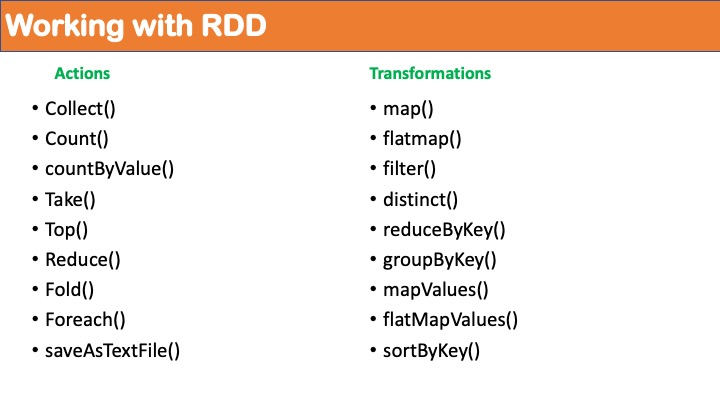

In [ ]:
Image(filename='RDD_Actions_Transformations.jpg')

## Create RDD and their Basic Actions

In [ ]:
names = sc.parallelize(['Adam','Cray','Shaun','Brain','Mark','Christ','Shail','Satya','Mark','Norby','Frans','Mark','Bill'])

In [ ]:
type(names)

pyspark.rdd.RDD

In [ ]:
names.collect()

['Adam',
 'Cray',
 'Shaun',
 'Brain',
 'Mark',
 'Christ',
 'Shail',
 'Satya',
 'Mark',
 'Norby',
 'Frans',
 'Mark',
 'Bill']

In [ ]:
type(a)

list

In [ ]:
names.countByValue()

defaultdict(int,
            {'Adam': 1,
             'Cray': 1,
             'Shaun': 1,
             'Brain': 1,
             'Mark': 3,
             'Christ': 1,
             'Shail': 1,
             'Satya': 1,
             'Norby': 1,
             'Frans': 1,
             'Bill': 1})

In [ ]:

def f(x): print(x)
a=sc.parallelize([1, 2, 3, 4, 5]).foreach(lambda x : print(x))

In [ ]:
type(a)

NoneType

In [ ]:
a=sc.parallelize([(1,2),(2,4)])

In [ ]:
a.countByValue()

In [ ]:
names.collect()

['Adam',
 'Cray',
 'Shaun',
 'Brain',
 'Mark',
 'Christ',
 'Shail',
 'Satya',
 'Mark',
 'Norby',
 'Frans',
 'Mark',
 'Bill']

In [ ]:
names.take(5)

['Adam', 'Cray', 'Shaun', 'Brain', 'Mark']

In [ ]:
employees = sc.textFile("employees.txt")

In [ ]:
type(employees)

pyspark.rdd.RDD

In [ ]:
employees.collect()

['Adam',
 'Cray',
 'Shaun',
 'Brain',
 'Mark',
 'Christ',
 'Shail',
 'Satya',
 'Mark',
 'Norby',
 'Frans',
 'Mark',
 'Bill']

In [ ]:
employees.first()

'Adam'

In [ ]:
employees.count()

13

In [ ]:
employees.top(5)

['Shaun', 'Shail', 'Satya', 'Norby', 'Mark']

In [ ]:
employees.top(19)

['Shaun',
 'Shail',
 'Satya',
 'Norby',
 'Mark',
 'Mark',
 'Mark',
 'Frans',
 'Cray',
 'Christ',
 'Brain',
 'Bill',
 'Adam']

In [ ]:
employees.distinct().count()

11

## Autres exemples

In [ ]:
num = sc.parallelize([5,5,4,3,2,9,2],9)
num.collect()

[5, 5, 4, 3, 2, 9, 2]

In [ ]:
num.take(4)

[5, 5, 4, 3]

In [ ]:
num.countByValue()

defaultdict(int, {5: 2, 4: 1, 3: 1, 2: 2, 9: 1})

In [ ]:
type(num)

pyspark.rdd.RDD

In [ ]:
#GLOM : RDD OF TUPLES

In [ ]:
num.glom().collect()

[[], [5], [5], [4], [], [3], [2], [9], [2]]

In [ ]:
type(num.glom())

pyspark.rdd.PipelinedRDD

In [ ]:
num.max()

9

In [ ]:
num.min()

2

In [ ]:
num.mean()

4.285714285714286

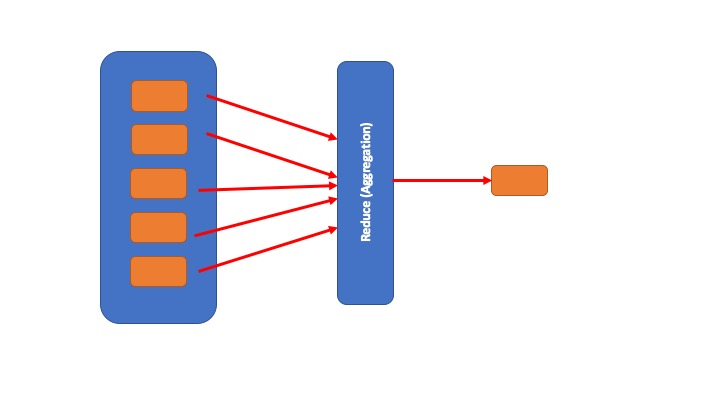

In [ ]:
Image(filename='Action_Reduce.jpg')

In [ ]:
num.collect()

[5, 5, 4, 3, 2, 9, 2]

In [ ]:
num.reduce(lambda a,b: a+b)

30

In [ ]:
num.reduce(lambda a,b: a*b)

10800

In [ ]:
num.reduce(lambda x,y: x if x > y else y)

9

In [ ]:
def myfun(a,b):
    return a*2 + b*2

In [ ]:
num.reduce(myfun)

872

In [ ]:
num.collect()

[5, 5, 4, 3, 2, 9, 2]

In [ ]:
num.takeOrdered(3)

[2, 2, 3]

In [ ]:
# fold: the initial value for the accumulated result of each partition for the op operator,
# and also the initial value for the combine results from different partitions

In [ ]:
num = sc.parallelize([5,5,4,3,2,9,2],2)
num.collect()

[5, 5, 4, 3, 2, 9, 2]

In [ ]:
num.glom().collect()

[[5, 5, 4], [3, 2, 9, 2]]

In [ ]:
num.reduce(lambda a,b: a+b)

30

In [ ]:
num.reduce(lambda a,b: a*b)

10800

In [ ]:
num.fold(2,lambda a,b:a+b)

34

In [ ]:
num.fold(2,lambda a,b : a*b )

86400

In [ ]:
from operator import add
b=sc.parallelize([1, 2, 3, 4, 5])
b.fold(1, add)


17

In [ ]:
from operator import add,mul
num3 = sc.parallelize([5,5,4,3,2,9,2]).fold(10,mul)
num3

1080000

In [ ]:
b = sc.parallelize(range(1,10))

In [ ]:
b.collect()

[1, 2, 3, 4, 5, 6, 7, 8, 9]

## Application:
Donner l'implémentation de Word Count avec Spark